# Traffic Sign Classifier
---


# Load The Data

In [40]:
import pickle
import matplotlib.pyplot as plt
import numpy as np
import random
import cv2
import time
# Visualizations will be shown in the notebook.
%matplotlib inline
from sklearn.model_selection import StratifiedShuffleSplit, train_test_split
import tensorflow as tf
from tensorflow.contrib.layers import flatten
from sklearn.utils import shuffle
from skimage import io


In [3]:
# Load pickled data


training_file = 'train.p'
training_augmented_file = 'train_augmented.p'
testing_file = 'test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
with open(training_augmented_file, mode='rb') as f:
    train_augmented = pickle.load(f)
    
X_train_original, y_train_original = train['features'], train['labels']
X_train_augmented, y_train_augmented = train_augmented['features'], train_augmented['labels']
X_test, y_test = test['features'], test['labels']

---

# Data Exploration

The pickled data is a dictionary with 2 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.


In [4]:

# Number of training examples
n_train = len(X_train_original)

# Number of testing examples.
n_test = len(X_test)

# Shape of an traffic sign image
image_shape = X_train_original[0].shape

# Number of unique classes/labels in the dataset
uniques = set().union(y_test, y_train_original)
n_classes = len(uniques)

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 39209
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


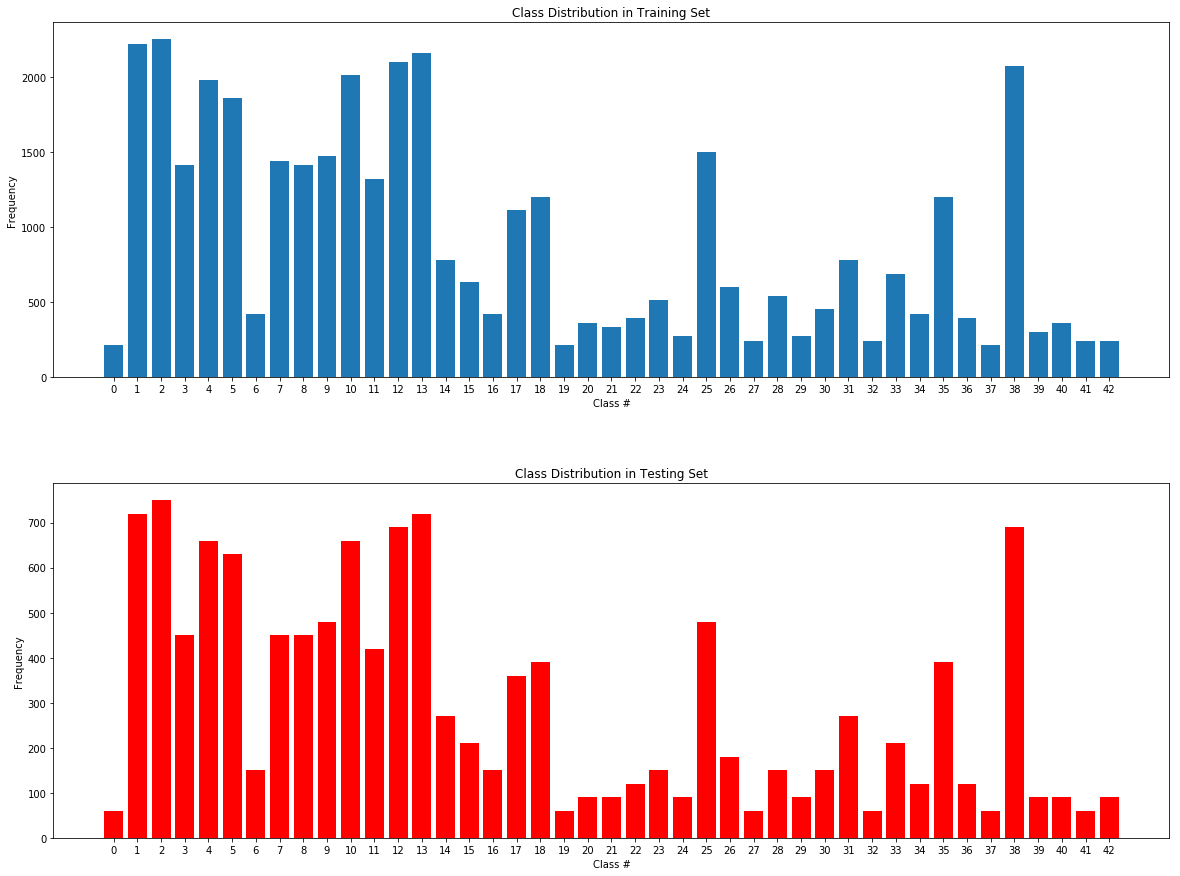

In [5]:
######
# Training set and testing set class distributions
######
fig, ax = plt.subplots(2, figsize=(20,15))
fig.subplots_adjust(hspace = .3)
labels, counts = np.unique(y_train_original, return_counts=True)
ax[0].bar(labels, counts)
ax[0].set_xticks(np.arange(43))
ax[0].set_xticklabels(labels)
ax[0].set_xlabel('Class #')
ax[0].set_ylabel('Frequency')
ax[0].set_title('Class Distribution in Training Set')
labels, counts = np.unique(y_test, return_counts=True)
ax[1].bar(labels, counts, color='red')
ax[1].set_xticks(np.arange(43))
ax[1].set_xticklabels(labels)
ax[1].set_xlabel('Class #')
ax[1].set_ylabel('Frequency')
ax[1].set_title('Class Distribution in Testing Set')

plt.show()


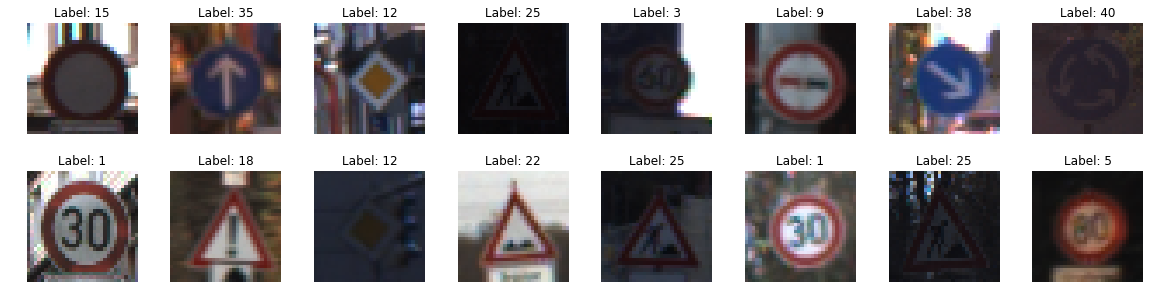

In [6]:

####
# Example images from the dataset
####
fig, axs = plt.subplots(2,8, figsize=(20,5))
fig.subplots_adjust(hspace = .2, wspace=.3)
axs = axs.ravel()
for i in range(0,16):
    index = random.randint(0, len(X_train_original))
    image = X_train_original[index].squeeze()
    axs[i].imshow(image)
    axs[i].axis('off')
    axs[i].set_title("Label: %d" % y_train_original[index])


# Data Augmentation

* Brightness
* Translation
* Perspective Transform aka Scaling
* Warping aka Affine warp

# Preprocessing

Preprocessing
* Grayscale
* Histogram Equalization
* Normalization

In [7]:


def preprocess(images):
    """
    Apply grayscale, histogram equalization, and pixel normalization on images

    Arguments:
        * images: Image data - each image should be 32x32x3

    Returns:
        *  Preprocessed image reshaped to 32x32, one-hot encoded labels
    """
    length = len(images)
    processed = np.empty([length, 32, 32])
    for i in range(length):
        img = cv2.cvtColor(images[i], cv2.COLOR_RGB2GRAY) #grayscale
        processed[i] = cv2.equalizeHist(img) # histogram equalization
        
            
    processed = (processed - 127.5)/127.5 # normalize [-1, 1]
    
    processed = np.expand_dims(processed, axis=3)
    return processed


########################################
# Preprocess trainging and testing data
########################################
X_train_preprocessed = preprocess(X_train_augmented)
X_test_preprocessed = preprocess(X_test)
print('done')


done


Original image shape:  (32, 32, 3)
Preprocessed image shape:  (32, 32, 1)


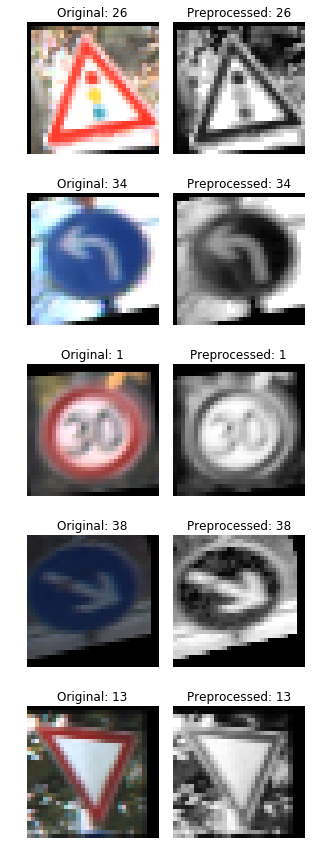

In [8]:

def visualize_preprocessing(original, preprocessed, labels):
    fig, axs = plt.subplots(5,2, figsize=(5,15))
    fig.subplots_adjust(hspace = .3, wspace=.1)
    axs = axs.ravel()
    
    print("Original image shape: ", original[0].shape)
    print("Preprocessed image shape: ", preprocessed[0].shape)
    for i in range(0,9,2):
        index = random.randint(0, len(original))
        original_img = original[index]
        axs[i].imshow(original_img)
        axs[i].axis('off')
        axs[i].set_title("Original: %d" % labels[index])
        preprocessed_img = preprocessed[index].squeeze()
        axs[i+1].imshow(preprocessed_img, cmap='gray')
        axs[i+1].axis('off')
        axs[i+1].set_title("Preprocessed: %d" % labels[index])

visualize_preprocessing(X_train_augmented, X_train_preprocessed, y_train_augmented)


# Model Architecture

In [9]:
########################
# LeNet-5 architecture
########################
def LeNet5(x):
    # Arguments used for tf.truncated_normal, randomly defines variables for the weights and biases for each layer
    mu = 0
    sigma = 0.1

    # Layer 1: Convolutional. Input = 32x32x1. Output = 28x28x6.
    conv1_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 1, 6), mean = mu, stddev = sigma))
    conv1_b = tf.Variable(tf.zeros(6))
    conv1   = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='VALID') + conv1_b

    # Activation.
    conv1 = tf.nn.relu(conv1)


    # Pooling. Input = 28x28x6. Output = 14x14x6.
    conv1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # Layer 2: Convolutional. Output = 10x10x16.
    conv2_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 6, 16), mean = mu, stddev = sigma))
    conv2_b = tf.Variable(tf.zeros(16))
    conv2   = tf.nn.conv2d(conv1, conv2_W, strides=[1, 1, 1, 1], padding='VALID') + conv2_b

    # Activation.
    conv2 = tf.nn.relu(conv2)



    # Pooling. Input = 10x10x16. Output = 5x5x16.
    conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # Flatten. Input = 5x5x16. Output = 400.
    fc0   = flatten(conv2)

    # Layer 3: Fully Connected. Input = 400. Output = 120.
    fc1_W = tf.Variable(tf.truncated_normal(shape=(400, 120), mean = mu, stddev = sigma))
    fc1_b = tf.Variable(tf.zeros(120))
    fc1   = tf.matmul(fc0, fc1_W) + fc1_b

    # Activation.
    fc1    = tf.nn.relu(fc1)

    # Layer 4: Fully Connected. Input = 120. Output = 84.
    fc2_W  = tf.Variable(tf.truncated_normal(shape=(120, 84), mean = mu, stddev = sigma))
    fc2_b  = tf.Variable(tf.zeros(84))
    fc2    = tf.matmul(fc1, fc2_W) + fc2_b

    # Activation.
    fc2    = tf.nn.relu(fc2)

    # Layer 5: Fully Connected. Input = 84. Output = 43.
    fc3_W  = tf.Variable(tf.truncated_normal(shape=(84, 43), mean = mu, stddev = sigma))
    fc3_b  = tf.Variable(tf.zeros(43))
    logits = tf.matmul(fc2, fc3_W) + fc3_b

    return logits




In [47]:
########################
# Architecture
########################
def Modified_LeNet(x):
    # Arguments used for tf.truncated_normal, randomly defines variables for the weights and biases for each layer
    mu = 0
    sigma = 0.1

    # Layer 1: Convolutional. Input = 32x32x1. Output = 30x30x16.
    conv1_W = tf.Variable(tf.truncated_normal(shape=(3, 3, 1, 16), mean = mu, stddev = sigma))
    conv1_b = tf.Variable(tf.zeros(16))
    conv1   = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='VALID') + conv1_b

    # Activation.
    conv1 = tf.nn.relu(conv1)

    # Pooling. Input = 30x30x16. Output = 15x15x16.
    conv1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # Layer 2: Convolutional. Input = 15x15x16. Output = 14x14x32.
    conv2_W = tf.Variable(tf.truncated_normal(shape=(2, 2, 16, 32), mean = mu, stddev = sigma))
    conv2_b = tf.Variable(tf.zeros(32))
    conv2   = tf.nn.conv2d(conv1, conv2_W, strides=[1, 1, 1, 1], padding='VALID') + conv2_b

    # Activation.
    conv2 = tf.nn.relu(conv2)

    # Pooling. Input = 14x14x32. Output = 7x7x32.
    conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # Flatten. Input = 7x7x32. Output = 1568.
    fc0   = flatten(conv2)

    # Layer 3: Fully Connected. Input = 1568. Output = 400.
    fc1_W = tf.Variable(tf.truncated_normal(shape=(1568, 400), mean = mu, stddev = sigma))
    fc1_b = tf.Variable(tf.zeros(400))
    fc1   = tf.matmul(fc0, fc1_W) + fc1_b

    # Activation.
    fc1    = tf.nn.relu(fc1)
    # Dropout
    fc1 = tf.nn.dropout(fc1, keep_prob)

    # Layer 4: Fully Connected. Input = 400. Output = 120.
    fc2_W  = tf.Variable(tf.truncated_normal(shape=(400, 120), mean = mu, stddev = sigma))
    fc2_b  = tf.Variable(tf.zeros(120))
    fc2    = tf.matmul(fc1, fc2_W) + fc2_b

    # Activation.
    fc2    = tf.nn.relu(fc2)
    # Dropout
    fc2 = tf.nn.dropout(fc2, keep_prob)
    
    # Layer 5: Fully Connected. Input = 120. Output = 43.
    fc3_W  = tf.Variable(tf.truncated_normal(shape=(120, 43), mean = mu, stddev = sigma))
    fc3_b  = tf.Variable(tf.zeros(43))
    logits = tf.matmul(fc2, fc3_W) + fc3_b

    return logits

In [48]:
def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 1})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

In [49]:
## Network hyperparameters
EPOCHS = 25
BATCH_SIZE = 128
LEARNING_RATE = 0.001
KEEP_PROB = 0.5
TEST_SIZE = 0.2
SAVE_PATH = './robertnet'

## TensorFlow placeholders
x = tf.placeholder(tf.float32, (None, 32, 32, 1))
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, 43)
keep_prob = tf.placeholder(tf.float32)   

## Define model architecture
#logits = LeNet5(x)
logits = Modified_LeNet(x)


## define loss function and optimizer
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits, one_hot_y)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate=LEARNING_RATE)
training_operation = optimizer.minimize(loss_operation)


## define evaluation / accuracy operations
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))





saver = tf.train.Saver()
accuracy_history = [(0,0)]

#################
# Train the model
#################
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    
    print("Training...")
    print()

    sss = StratifiedShuffleSplit(n_splits=EPOCHS, test_size=TEST_SIZE, random_state=0)
    epoch_num = 0
    for train_index, test_index in sss.split(X_train_preprocessed, y_train_augmented):
        start_time = time.time()
        X_train, y_train = X_train_preprocessed[train_index], y_train_augmented[train_index]
        num_examples = len(X_train)
        #fig, ax = plt.subplots(1, figsize=(20,6))
        #fig.subplots_adjust(hspace = .3)
        #labels, counts = np.unique(batch_y, return_counts=True)
        #ax.bar(labels, counts)
        #ax.set_xticks(np.arange(43))
        #ax.set_xticklabels(labels)
        #ax.set_xlabel('Class #')
        #ax.set_ylabel('Frequency')
        #ax.set_title('Class Distribution in Batch')
        #plt.show()
        
        
        for offset in range(0, num_examples, BATCH_SIZE):
            batch_x, batch_y = X_train[offset:offset+BATCH_SIZE], y_train[offset:offset+BATCH_SIZE]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: KEEP_PROB})
            
        training_accuracy = evaluate(X_train, y_train)
        
        X_validation, y_validation = X_train_preprocessed[test_index], y_train_augmented[test_index] 
        
        validation_accuracy = evaluate(X_validation, y_validation)
        print("EPOCH {} ...".format(epoch_num+1))
        print("Training Accuracy = {:.3f}".format(training_accuracy))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        elapsed_time = time.time()-start_time
        print("Elapsed Time: %.2f sec" % elapsed_time)
        print()
            
        epoch_num += 1
        
        
        accuracy_history.append((training_accuracy, validation_accuracy))

    saver.save(sess, SAVE_PATH)
    print("Model saved")

Training...

EPOCH 1 ...
Training Accuracy = 0.747
Validation Accuracy = 0.740
Elapsed Time: 103.34 sec

EPOCH 2 ...
Training Accuracy = 0.854
Validation Accuracy = 0.843
Elapsed Time: 99.90 sec

EPOCH 3 ...
Training Accuracy = 0.897
Validation Accuracy = 0.889
Elapsed Time: 100.55 sec

EPOCH 4 ...
Training Accuracy = 0.926
Validation Accuracy = 0.921
Elapsed Time: 100.09 sec

EPOCH 5 ...
Training Accuracy = 0.948
Validation Accuracy = 0.942
Elapsed Time: 102.47 sec

EPOCH 6 ...
Training Accuracy = 0.953
Validation Accuracy = 0.944
Elapsed Time: 96.73 sec

EPOCH 7 ...
Training Accuracy = 0.966
Validation Accuracy = 0.957
Elapsed Time: 100.19 sec

EPOCH 8 ...
Training Accuracy = 0.974
Validation Accuracy = 0.968
Elapsed Time: 99.81 sec

EPOCH 9 ...
Training Accuracy = 0.976
Validation Accuracy = 0.971
Elapsed Time: 100.43 sec

EPOCH 10 ...
Training Accuracy = 0.980
Validation Accuracy = 0.975
Elapsed Time: 100.72 sec

EPOCH 11 ...
Training Accuracy = 0.979
Validation Accuracy = 0.973
El

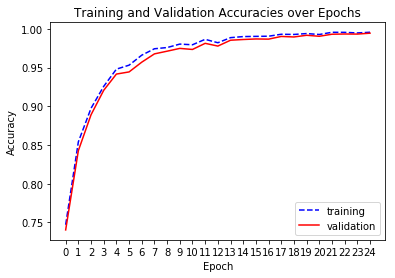

In [54]:

#accuracy_shortened = accuracy_history[1:]
hist = np.transpose(np.array(accuracy_shortened))
train_history = hist[0]
t, = plt.plot(train_history, 'b', linestyle='--', label='training')
validation_history = hist[1]
v, = plt.plot(validation_history, 'r', label='validation') 
plt.legend(handles=[t, v])
plt.title('Training and Validation Accuracies over Epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.xticks(np.arange(EPOCHS))
plt.show()




In [51]:
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))

    test_accuracy = evaluate(X_test_preprocessed, y_test)
    print("Test Accuracy = {:.3f}".format(test_accuracy))

Test Accuracy = 0.955


5 New Test Images


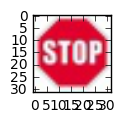

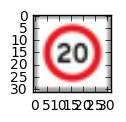

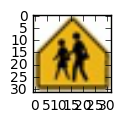

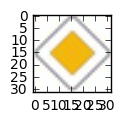

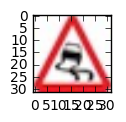

In [70]:

stop_img = io.imread('stop.jpg')
plt.figure(figsize=(1,1))
plt.imshow(stop_img)
kph_img = io.imread('20kmh.jpg')
plt.figure(figsize=(1,1))
plt.imshow(kph_img)
ped_img = io.imread('pedestrian.jpg')
plt.figure(figsize=(1,1))
plt.imshow(ped_img)
priority_img = io.imread('priority.jpg')
plt.figure(figsize=(1,1))
plt.imshow(priority_img)
slippery_img = io.imread('slippery.jpg')
plt.figure(figsize=(1,1))
plt.imshow(slippery_img)
print("5 New Test Images")

### Question 6

_Choose five candidate images of traffic signs and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult? It could be helpful to plot the images in the notebook._



**Answer:**
I got these images from the internet and they do not have any notable distortions or obstructions that would make classification difficult. The fact that they are "zoomed in" or larger than what you might expect from a picture of a sign taken from a few feet away, could be a notable difference from the images that the model trained on. 

In [71]:
### Run the predictions here.
### Feel free to use as many code cells as needed.

with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))

    stop_accuracy = evaluate([stop_img], [14])
    print("Stop Sign Accuracy = {:.3f}".format(stop_accuracy))
    
    ped_accuracy = evaluate([ped_img], [27])
    print("Pedestrian Sign Accuracy = {:.3f}".format(ped_accuracy))
    
    kph_accuracy = evaluate([kph_img], [0])
    print("Speed Limit 20 Sign Accuracy = {:.3f}".format(kph_accuracy))
    
    priority_accuracy = evaluate([priority_img], [12])
    print("Priority Road Sign Accuracy = {:.3f}".format(priority_accuracy))
    
    slippery_accuracy = evaluate([slippery_img], [23]) 
    print("Slippery Road Sign Accuracy = {:.3f}".format(slippery_accuracy))

Stop Sign Accuracy = 1.000
Pedestrian Sign Accuracy = 0.000
Speed Limit 20 Sign Accuracy = 0.000
Priority Road Sign Accuracy = 1.000
Slippery Road Sign Accuracy = 1.000


### Question 7

_Is your model able to perform equally well on captured pictures when compared to testing on the dataset? The simplest way to do this check the accuracy of the predictions. For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate._

_**NOTE:** You could check the accuracy manually by using `signnames.csv` (same directory). This file has a mapping from the class id (0-42) to the corresponding sign name. So, you could take the class id the model outputs, lookup the name in `signnames.csv` and see if it matches the sign from the image._


**Answer:**
The model's performance on the new test images was mediocre - 60%. It was close on the 20kph sign (though it was 120kph). And I think the pedestrian sign I provided is different that the pedestrian signs it has been trained on (American vs European signs). 

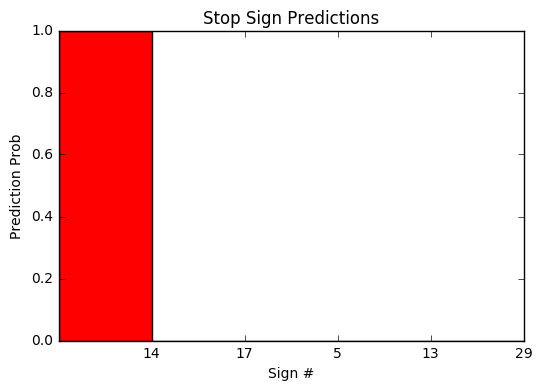

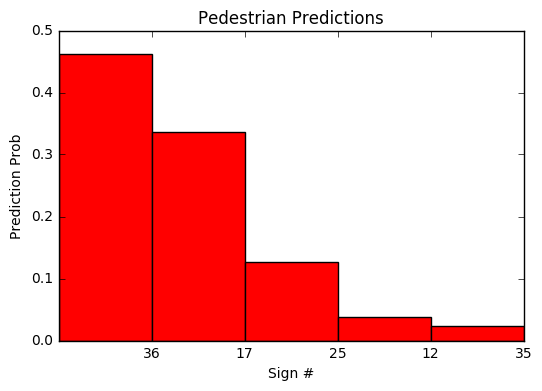

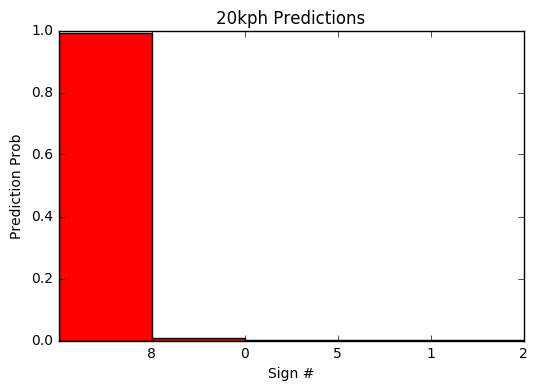

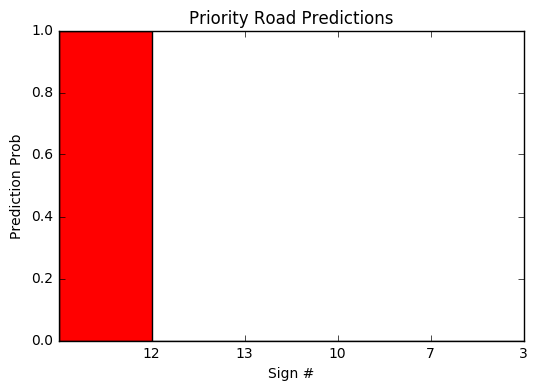

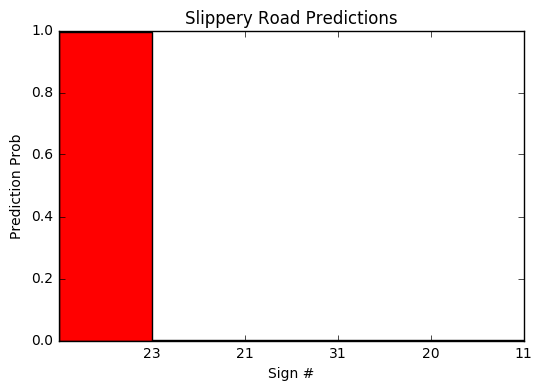

In [72]:
### Visualize the softmax probabilities here.
### Feel free to use as many code cells as needed.
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    
    sftmax = tf.nn.softmax(logits)
    top_k_operation = tf.nn.top_k(sftmax, 5, sorted=True)
    
    image_names = ["Stop Sign", "Pedestrian", "20kph", "Priority Road", "Slippery Road"]
    images = [stop_img, ped_img, kph_img, priority_img, slippery_img]
    
    for i in range(0, 5):
        top_k_results = sess.run(top_k_operation, feed_dict={x: [images[i]], keep_prob: 1})
        top_k_values = top_k_results[0]
        top_k_indices = top_k_results[1]

        ind = np.arange(5) 
        width = 1       

        values = top_k_values[0]
        plt.bar(ind, values, width, color='r')
        plt.ylabel('Prediction Prob')
        plt.xlabel('Sign #')
        plt.title("%s Predictions" % image_names[i])
        plt.xticks(ind+width, tuple(top_k_indices[0]))

        plt.show()


### Question 8

*Use the model's softmax probabilities to visualize the **certainty** of its predictions, [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. Which predictions is the model certain of? Uncertain? If the model was incorrect in its initial prediction, does the correct prediction appear in the top k? (k should be 5 at most)*

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, you can confirm these are the 3 largest probabilities in `a`. You'll also notice `[3, 0, 5]` are the corresponding indices.

**Answer:**
The softmax probabilities show that my model was confident on one of the images that it got wrong! 
It was very confident about the 20kph speed limit sign being a 120 kph sign - close, but perhaps dangerously wrong! 20kph came in as second highest probability 
It was unable to identify the pedestrian in its top 5 probabilities. This may be due to the difference in pedestrian signs. I provided an "American" pdedestrian sign which is different

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.